<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
# Manually unpgrading albumentations so the issue with ContextVersion not found when installing evalib is removed.
!pip uninstall albumentations -y
!pip uninstall imgaug -y
!pip install albumentations --upgrade

In [0]:
!pip install git+https://github.com/gantir/evalib.git@develop

In [4]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
except:
  print('May be not using Google Colab')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from __future__ import print_function
import sys
from argparse import Namespace

import torch
import torchvision
from torchvision import  transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from matplotlib.pyplot import imshow

In [6]:
import evalib
from evalib.gradcam.gradcam import GradCAM, GradCAMpp
from evalib.gradcam.utils import visualize_cam
from evalib.lr import lr_finder


  pip install torch-lr-finder -v --global-option="amp"


In [0]:
config = Namespace(
    batch_size = 64,
    batch_size_cuda = 64,
    num_workers = 4,
    SEED = 170,
    EPOCHS = 25,
    dropout = 0.0,
    lr = 1e-3,
    momentum = 0.9,
    l1_decay =  0,
    l2_decay = 1e-4   
)
evalib.utils.init_seed(config.SEED)

In [8]:
data = evalib.data.cifar.CIFAR(config)

Files already downloaded and verified


 deer   dog truck  bird


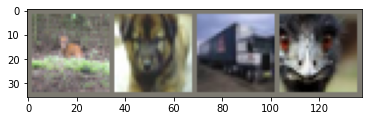

In [9]:
data_iter = iter(data.test_loader)
images, labels = data_iter.next()
index_start, index_end = 32,36
evalib.plot.imshow_torch(torchvision.utils.make_grid(images[index_start:index_end]))
print(' '.join('%5s' % data.classes[label] for label in labels[index_start:index_end]))

# imshow(transforms.ToPILImage()(images[32]))

In [11]:
net = evalib.models.resnet.ResNet18(config.dropout)
model = net.to(evalib.utils.get_device())
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
def configure_optimizers(params, conf):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params, lr=conf.lr, momentum=conf.momentum, weight_decay=conf.l2_decay)
  # scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
  scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)
  return criterion, optimizer, scheduler

In [25]:
criterion, optimizer, scheduler = configure_optimizers(model.parameters(), config)

lr_f = lr_finder.LRFinder(model, optimizer, criterion, device=evalib.utils.get_device())
lr_f.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-5, end_lr=2, num_iter=len(data.train_loader), step_mode="exp")
lr_f.plot()
lr_f.reset()



Learning rate search finished. See the graph with {finder_name}.plot()


In [27]:
best_lr = lr_f.history['lr'][lr_f.history['loss'].index(lr_f.best_loss)]
print("Best LR: {}".format(best_lr))
config.lr = best_lr


Best LR: 0.0021811709453896655


In [0]:
config.lr = 0.0021811709453896655
criterion, optimizer, scheduler = configure_optimizers(model.parameters(), config)

In [14]:
[(train_acc, train_loss), (val_acc, val_loss)] = evalib.tnt.train_n_test(model, criterion, optimizer, scheduler, data.train_loader, data.test_loader, num_epochs=config.EPOCHS)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


Batch Id/Size: 782/50000, Training Loss: 1.61706793, Training Accuracy: 48.4060%: 100%|██████████| 782/782 [00:58<00:00, 13.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01624170, Test Accuracy: 63.7800%

Epoch: 2


Batch Id/Size: 782/50000, Training Loss: 1.23060822, Training Accuracy: 65.0620%: 100%|██████████| 782/782 [00:59<00:00, 13.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01219692, Test Accuracy: 72.2800%

Epoch: 3


Batch Id/Size: 782/50000, Training Loss: 1.08127606, Training Accuracy: 71.8220%: 100%|██████████| 782/782 [00:59<00:00, 13.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01001754, Test Accuracy: 77.6400%

Epoch: 4


Batch Id/Size: 782/50000, Training Loss: 0.73864007, Training Accuracy: 75.5740%: 100%|██████████| 782/782 [00:59<00:00, 13.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00947136, Test Accuracy: 79.5100%

Epoch: 5


Batch Id/Size: 782/50000, Training Loss: 1.01942182, Training Accuracy: 78.5580%: 100%|██████████| 782/782 [00:59<00:00, 13.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00969447, Test Accuracy: 79.2300%

Epoch: 6


Batch Id/Size: 782/50000, Training Loss: 0.52939099, Training Accuracy: 80.5420%: 100%|██████████| 782/782 [00:59<00:00, 13.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00915305, Test Accuracy: 80.6400%

Epoch: 7


Batch Id/Size: 782/50000, Training Loss: 0.63389999, Training Accuracy: 82.1860%: 100%|██████████| 782/782 [00:59<00:00, 13.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00805923, Test Accuracy: 83.2200%

Epoch: 8


Batch Id/Size: 782/50000, Training Loss: 0.59213018, Training Accuracy: 83.6060%: 100%|██████████| 782/782 [00:59<00:00, 13.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00783253, Test Accuracy: 83.3100%

Epoch: 9


Batch Id/Size: 782/50000, Training Loss: 0.40975225, Training Accuracy: 84.7800%: 100%|██████████| 782/782 [00:59<00:00, 13.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00728200, Test Accuracy: 84.7400%

Epoch: 10


Batch Id/Size: 782/50000, Training Loss: 0.17737260, Training Accuracy: 85.9720%: 100%|██████████| 782/782 [00:59<00:00, 13.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00729983, Test Accuracy: 84.7900%

Epoch: 11


Batch Id/Size: 782/50000, Training Loss: 0.23160097, Training Accuracy: 87.0940%: 100%|██████████| 782/782 [00:59<00:00, 13.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00719494, Test Accuracy: 84.9100%

Epoch: 12


Batch Id/Size: 782/50000, Training Loss: 0.35860160, Training Accuracy: 87.8760%: 100%|██████████| 782/782 [00:59<00:00, 13.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00687903, Test Accuracy: 85.7500%

Epoch: 13


Batch Id/Size: 782/50000, Training Loss: 0.09732096, Training Accuracy: 88.5880%: 100%|██████████| 782/782 [00:59<00:00, 13.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00731773, Test Accuracy: 85.1000%

Epoch: 14


Batch Id/Size: 782/50000, Training Loss: 0.14019594, Training Accuracy: 89.1680%: 100%|██████████| 782/782 [00:59<00:00, 13.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00667284, Test Accuracy: 86.5300%

Epoch: 15


Batch Id/Size: 782/50000, Training Loss: 0.19945282, Training Accuracy: 89.8400%: 100%|██████████| 782/782 [00:59<00:00, 13.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00669595, Test Accuracy: 86.6500%

Epoch: 16


Batch Id/Size: 782/50000, Training Loss: 0.25887769, Training Accuracy: 90.4840%: 100%|██████████| 782/782 [00:59<00:00, 13.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00737147, Test Accuracy: 85.4000%

Epoch: 17


Batch Id/Size: 782/50000, Training Loss: 0.43660206, Training Accuracy: 91.1300%: 100%|██████████| 782/782 [00:59<00:00, 13.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00714552, Test Accuracy: 86.3200%

Epoch: 18


Batch Id/Size: 782/50000, Training Loss: 0.19068187, Training Accuracy: 91.4980%: 100%|██████████| 782/782 [00:59<00:00, 13.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00696714, Test Accuracy: 86.3900%

Epoch    18: reducing learning rate of group 0 to 2.1812e-04.
Epoch: 19


Batch Id/Size: 782/50000, Training Loss: 0.04400501, Training Accuracy: 94.0100%: 100%|██████████| 782/782 [00:59<00:00, 13.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00539696, Test Accuracy: 89.0000%

Epoch: 20


Batch Id/Size: 782/50000, Training Loss: 0.16088128, Training Accuracy: 94.8080%: 100%|██████████| 782/782 [00:59<00:00, 13.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00528893, Test Accuracy: 89.2700%

Epoch: 21


Batch Id/Size: 782/50000, Training Loss: 0.11606634, Training Accuracy: 95.2920%: 100%|██████████| 782/782 [00:59<00:00, 13.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00527071, Test Accuracy: 89.4500%

Epoch: 22


Batch Id/Size: 782/50000, Training Loss: 0.00740236, Training Accuracy: 95.5920%: 100%|██████████| 782/782 [00:59<00:00, 13.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00528571, Test Accuracy: 89.6000%

Epoch: 23


Batch Id/Size: 782/50000, Training Loss: 0.04646380, Training Accuracy: 96.0380%: 100%|██████████| 782/782 [00:59<00:00, 13.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00523786, Test Accuracy: 89.7600%

Epoch: 24


Batch Id/Size: 782/50000, Training Loss: 0.00720954, Training Accuracy: 96.1280%: 100%|██████████| 782/782 [00:59<00:00, 13.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00524250, Test Accuracy: 89.5700%

Epoch: 25


Batch Id/Size: 782/50000, Training Loss: 0.03087875, Training Accuracy: 96.1580%: 100%|██████████| 782/782 [00:59<00:00, 13.15it/s]
100%|██████████| 157/157 [00:03<00:00, 44.01it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00526776, Test Accuracy: 89.8400%



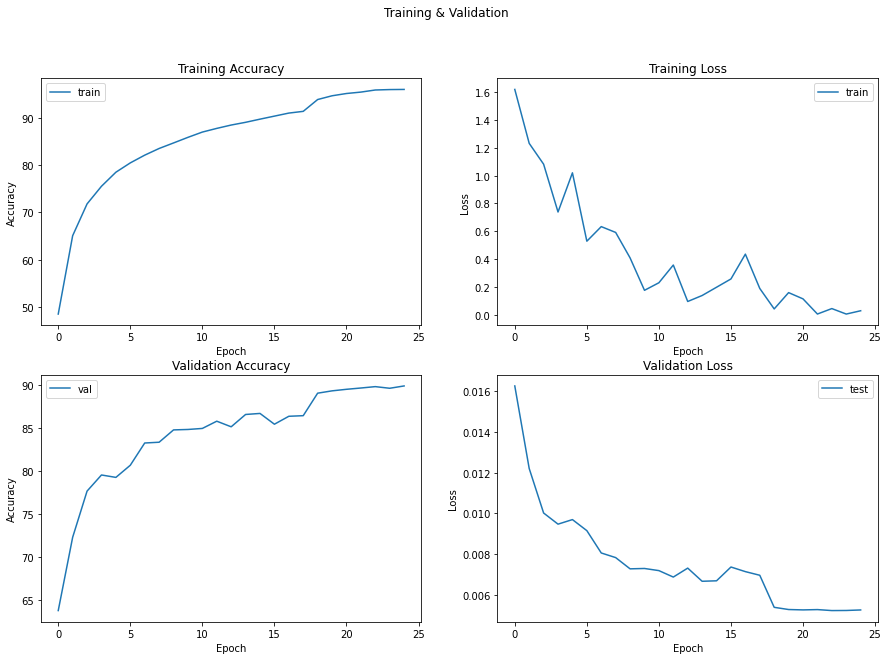

In [15]:
evalib.plot.plot_acc_loss(
    {'train': train_acc},
    {'val': val_acc},
    {'train': train_loss},
    {'test': val_loss}
)

In [0]:
c,w = evalib.tnt.get_correct_wrong_predictions(model, data.test_loader,count=25)

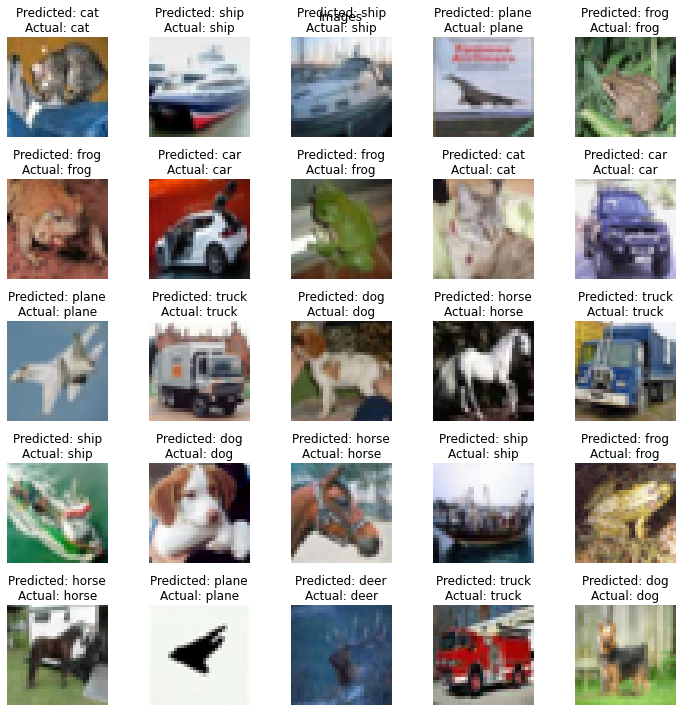

In [17]:
evalib.plot.plot_images(c, data.classes, "correct_imgs.png")


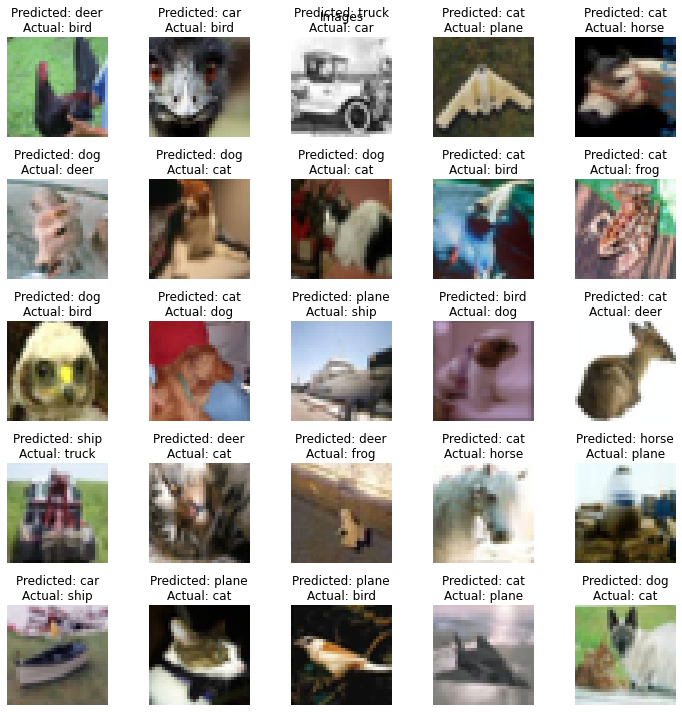

In [18]:
evalib.plot.plot_images(w, data.classes, "wrong_imgs.png")


In [0]:
# Grad Cam
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer1'),
    dict(model_type='resnet', arch=model, layer_name='layer2'),
    dict(model_type='resnet', arch=model, layer_name='layer3'),
    dict(model_type='resnet', arch=model, layer_name='layer4'),
]

for config in configs:
    config['arch'].to(evalib.utils.get_device()).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [0]:
torch_images = [i['img'].to(evalib.utils.get_device()) for i in w]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


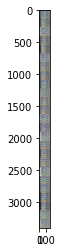

In [24]:
images = []
for torch_img in torch_images:
  normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
  for gradcam, gradcam_pp in cams:
      mask, _ = gradcam(normed_torch_img)
      heatmap, result = visualize_cam(mask, torch_img)

      mask_pp, _ = gradcam_pp(normed_torch_img)
      heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
      
      images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = torchvision.utils.make_grid(images, nrow=5)
evalib.plot.imshow_torch(grid_image)

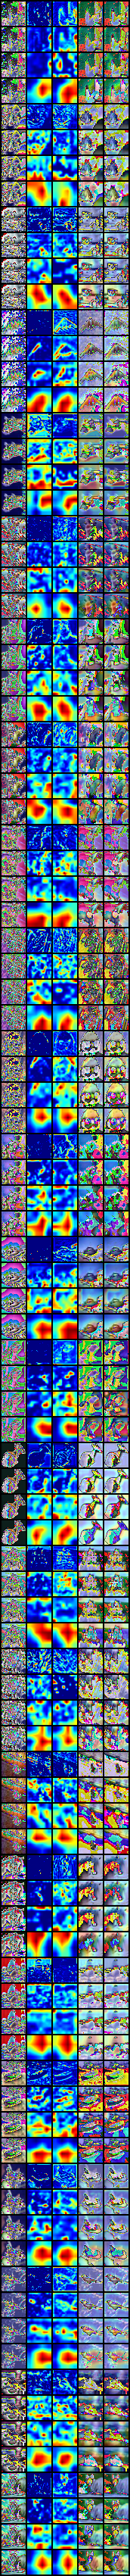

In [25]:
transforms.ToPILImage()(grid_image)
